In [1]:
! pip -q install equinox optax

In [2]:
import equinox as eqx
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
import optax
import time

from jax import random, vmap
from jax.lax import dot_general, scan
from jax.nn import gelu
from jax.scipy.special import logsumexp
from jax.tree_util import tree_map, tree_flatten

%config InlineBackend.figure_format='retina'

# Self-attention and multi-head self-attention

For vision transformer we need encoder from [Attention Is All You Need](https://arxiv.org/abs/1706.03762). The description of encoder can be also found in [ViT paper](https://arxiv.org/abs/2010.11929) and in various tutorials, e.g., [An introduction to Transformers](https://arxiv.org/abs/2304.10557). The main part of the encoder is a self-attention mechanism, that transform representation of each token in the input sequence based on the context given by other tokens in the sequnce. For that we:
1. Splits the input sequence $x_{i}\in\mathbb{R}^{N_{\text{features}}},\,i=1,\dots,N_{\text{tokens}}$ on key, query, value
\begin{equation}
  \begin{split}
   &k_i = W_{K} x_{i},\\
   &q_i = W_{Q} x_{i},\\
   &v_i = W_{V} x_{i}.\\
  \end{split}
\end{equation}
2. Use key and query to find attention weights
\begin{equation}
  w_{ij} = \exp(q_{i}^{\top} k_{j}) \big/\sum_{j} \exp(q_{i}^{\top} k_{j}).
\end{equation}
3. Form output from value and attention weights
\begin{equation}
  \widetilde{x}_{i} = \sum_{j}w_{ij} v_{j}.
\end{equation}

Self-attention is typically applied with several "attention heads". To add heads one needs:
1. Apply self-attention with $L$ independent $W_{K}, W_{Q}, W_{V}$ to get $\widetilde{x}^{(h)}_{i},\,i=1,\dots, N_{\text{tokens}},\,h=1,\dots, L$.
2. Form output as a linear combination of self-attention outputs $\widetilde{x}_{i} = \sum_{h=1}^{L}A^{(h)} \widetilde{x}^{(h)}_{i}$, where $A^{(h)}$ is the set of additional parameters.

In [3]:
def self_attention(tokens, Q, K, V):
    # tokens.shape = (N_features, N_samples), Q.shape = (f_internal, N_features), K.shape = (f_internal, N_features), V.shape = (f_out, N_features), output.shape = (f_out, N_samples)
    q, k, v = Q @ tokens, K @ tokens, V @ tokens
    weights = q.T @ k / jnp.sqrt(q.shape[0])
    weights = jnp.exp(weights - jnp.max(weights, axis=0, keepdims=True))
    tokens = v @ weights / jnp.sum(weights, axis=0, keepdims=True)
    return tokens

def multihead_self_attention(tokens, Q, K, V, M):
    # tokens.shape = (N_features, N_samples), Q.shape = (h, f_internal, N_features), K.shape = (h, f_internal, N_features), V.shape = (h, f_out_1, N_features), M.shape = (h, f_out, f_out_1), output.shape = (f_out, N_samples)
    tokens = vmap(self_attention, in_axes=(None, 0, 0, 0))(tokens, Q, K, V)
    tokens = jnp.sum(dot_general(M, tokens, (((2,), (1,)), ((0,), (0,)))), axis=0)
    return tokens

In [4]:
N_samples = 50
N_features = 30
tokens = random.normal(random.PRNGKey(11), (N_features, N_samples))

N_inner = 17
N_out = 15
keys = random.split(random.PRNGKey(11), 3)
Q = random.normal(keys[0], (N_inner, N_features))
K = random.normal(keys[1], (N_inner, N_features))
V = random.normal(keys[2], (N_out, N_features))

tokens_ = self_attention(tokens, Q, K, V)
print(tokens_.shape)

(15, 50)


In [5]:
N_samples = 51
N_features = 30
tokens = random.normal(random.PRNGKey(11), (N_features, N_samples))

N_heads = 13
N_inner = 17
N_inner_ = 27
N_out = 23
keys = random.split(random.PRNGKey(11), 4)
Q = random.normal(keys[0], (N_heads, N_inner, N_features))
K = random.normal(keys[1], (N_heads, N_inner, N_features))
V = random.normal(keys[2], (N_heads, N_inner_, N_features))
M = random.normal(keys[3], (N_heads, N_out, N_inner_))

tokens_ = multihead_self_attention(tokens, Q, K, V, M)
print(tokens_.shape)

(23, 51)


# Vision transformer

ViT architecture is clearly explained in the [ViT paper](https://arxiv.org/abs/2010.11929). It is essentially the same as a Transformer decoder with four minor modifications:

1. Positional encoding is learnable.

   These weights are interpolated when ViT is applied to pictures with resolution different from the one of the training set.

2. Additional learnable classicication token is stacked at the beginning of the sequence.

3. After the final seq-to-seq transformer layer representation of this token enters the classification head (MLP).

4. Special tokeniser suitable for images.

   Explained below.


All that is implemented below along with training loop and standard corss-entropy loss.

In [6]:
def normalize_conv(A):
    A = eqx.tree_at(lambda x: x.weight, A, A.weight*jnp.sqrt(2/A.weight.shape[1]))
    A = eqx.tree_at(lambda x: x.bias, A, jnp.zeros_like(A.bias))
    return A

def compute_loss(model, tokens, classes):
    outputs = vmap(model)(tokens)
    loss = jnp.mean(logsumexp(outputs, axis=1) - vmap(jnp.take, in_axes=[0, 0, None])(outputs, classes, 0))
    return loss

compute_loss_and_grads = eqx.filter_value_and_grad(compute_loss)

def make_step_scan(carry, ind, optim):
    features, classes, model, opt_state = carry
    loss, grads = compute_loss_and_grads(model, features[ind], classes[ind])
    grads = tree_map(jnp.conj, grads)
    updates, opt_state = optim.update(grads, opt_state, eqx.filter(model, eqx.is_array))
    model = eqx.apply_updates(model, updates)
    return [features, classes, model, opt_state], loss

def compute_accuracy(carry, ind):
    tokens, classes, model = carry
    outputs = vmap(model)(tokens[ind])
    predictions = jnp.argmax(outputs, axis=1)
    hits_and_misses = predictions == classes[ind]
    return [tokens, classes, model], hits_and_misses

class MHSA_block(eqx.Module):
    Q: jnp.array
    K: jnp.array
    V: jnp.array
    M: jnp.array
    layer_norms: list
    MLP: list

    def __init__(self, key, N_features, N_similarity, N_inner, N_head, N_MLP):
        keys = random.split(key, 5)
        norm_factor = jnp.sqrt(2/N_features)
        self.Q = random.normal(keys[0], (N_heads, N_similarity, N_features)) * norm_factor
        self.K = random.normal(keys[1], (N_heads, N_similarity, N_features)) * norm_factor
        self.V = random.normal(keys[2], (N_heads, N_features, N_features)) * norm_factor
        self.M = random.normal(keys[3], (N_heads, N_features, N_features)) * norm_factor
        keys = random.split(keys[4], N_MLP)
        self.MLP = [normalize_conv(eqx.nn.Conv(1, N_features, N_features, 1, key=key)) for key in keys]
        self.layer_norms = [eqx.nn.LayerNorm((N_features,)), eqx.nn.LayerNorm((N_features,))]

    def __call__(self, tokens):
        tokens = tokens + multihead_self_attention(vmap(self.layer_norms[0], in_axes=1, out_axes=1)(tokens), self.Q, self.K, self.V, self.M)
        tokens_ = vmap(self.layer_norms[1], in_axes=1, out_axes=1)(tokens)
        for conv in self.MLP:
            tokens_ = gelu(conv(tokens_))
        tokens = tokens + tokens_
        return tokens

class ViT_classifier(eqx.Module):
    po_M: jnp.array
    po_v: jnp.array
    MHSA_blocks: list
    class_token: jnp.array
    MLP: list

    def __init__(self, key, N_features, N_head, N_MLP, N_blocks, length, N_classes, N_c_layers, N_c_features):
        keys = random.split(key, N_blocks+3)
        self.po_M = random.normal(keys[0], (N_features[1], N_features[0])) * jnp.sqrt(2/N_features[0])
        self.po_v = jnp.zeros((N_features[1], length))
        self.class_token = random.normal(keys[1], (N_features[1], 1))
        self.MHSA_blocks = [MHSA_block(key, N_features[1], N_features[1], N_inner, N_head, N_MLP) for key in keys[3:]]
        keys = random.split(keys[2], N_c_layers)
        N_features = [N_features[1],] + [N_c_features,]*(N_c_layers-1) + [N_classes,]
        self.MLP = [normalize_conv(eqx.nn.Conv(1, f_in, f_out, 1, key=key)) for f_in, f_out, key in zip(N_features[:-1], N_features[1:], keys)]

    def __call__(self, tokens):
        tokens = self.po_M @ tokens + self.po_v
        tokens = jnp.concatenate([self.class_token, tokens], axis=1)
        for a_block in self.MHSA_blocks:
            tokens = a_block(tokens)
        u = tokens[:, :1]
        u = self.MLP[0](u)
        for m in self.MLP[1:]:
            u = gelu(u)
            u = m(u)
        return u[:, 0]

# MNIST preprocessing

To apply Transformer one need to have a sequence of tokens. The end of tokenizer is to provide this sequence given an image as an output. An image is a tensor $W\in\mathbb{R}^{N_{x}\times N_{y} \times N_{c}}$. To obtain a sequence we split image on $N\times M$ blocks, where both $N$ and $M$ are hyperparameters ($16$ and $16$ in the original paper). This procedure leave us with $N\times M$ tensors $T_{i}$ of sizes $(N_{x} / N, N_{y} / M, N_{c})$. To obtain tokens we transform this tensors with affine transformation
\begin{equation}
  t_{i} = A\text{vec}(T_{i}) + p_{i},
\end{equation}
where $A$ is a shared learnable linear transformation and $p_{i}$ are learnable positional embeddings.

An example how to cut image is given below.

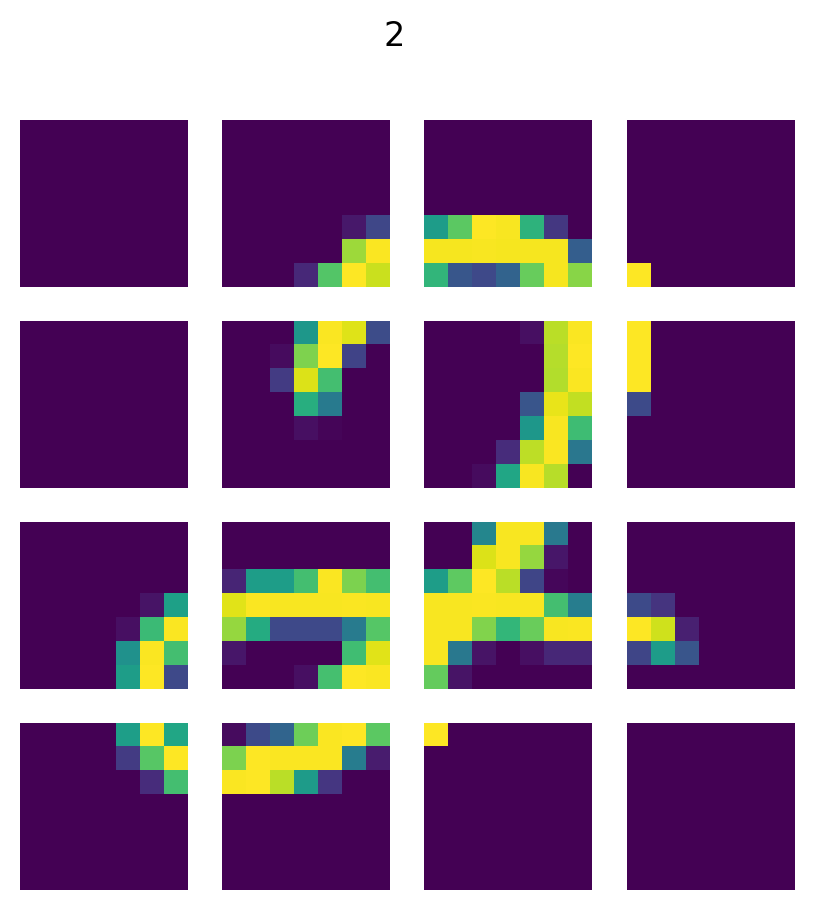

In [7]:
train_data = pd.read_csv("/content/sample_data/mnist_train_small.csv", header=None).to_numpy()
test_data = pd.read_csv("/content/sample_data/mnist_test.csv", header=None).to_numpy()
N_train = train_data.shape[0]

classes = jnp.concatenate([train_data[:, 0], test_data[:, 0]], axis=0)
features = jnp.concatenate([train_data[:, 1:], test_data[:, 1:]], axis=0)

# 4 x 4 blocks of size 7 x 7
features = jnp.transpose(features.reshape(-1, 28, 28, order="C").reshape(-1, 7, 4, 7, 4, order="F"), [0, 1, 3, 2, 4])

# visualisation of blocks
sample = 5
fig, ax = plt.subplots(4, 4, figsize=(5, 5), sharex=True, sharey=True)
for i in range(4):
    for j in range(4):
        ax[i, j].imshow(features[sample, :, :, i, j])
        ax[i, j].axis("off")
fig.suptitle(f"{classes[sample]}");

features = features.reshape(-1, 49, 16)

# Training and evaluation

Model size: 132690
Trainig time: 70.86649227142334
Train accuracy 0.9829999804496765
Test accuracy 0.9138000011444092


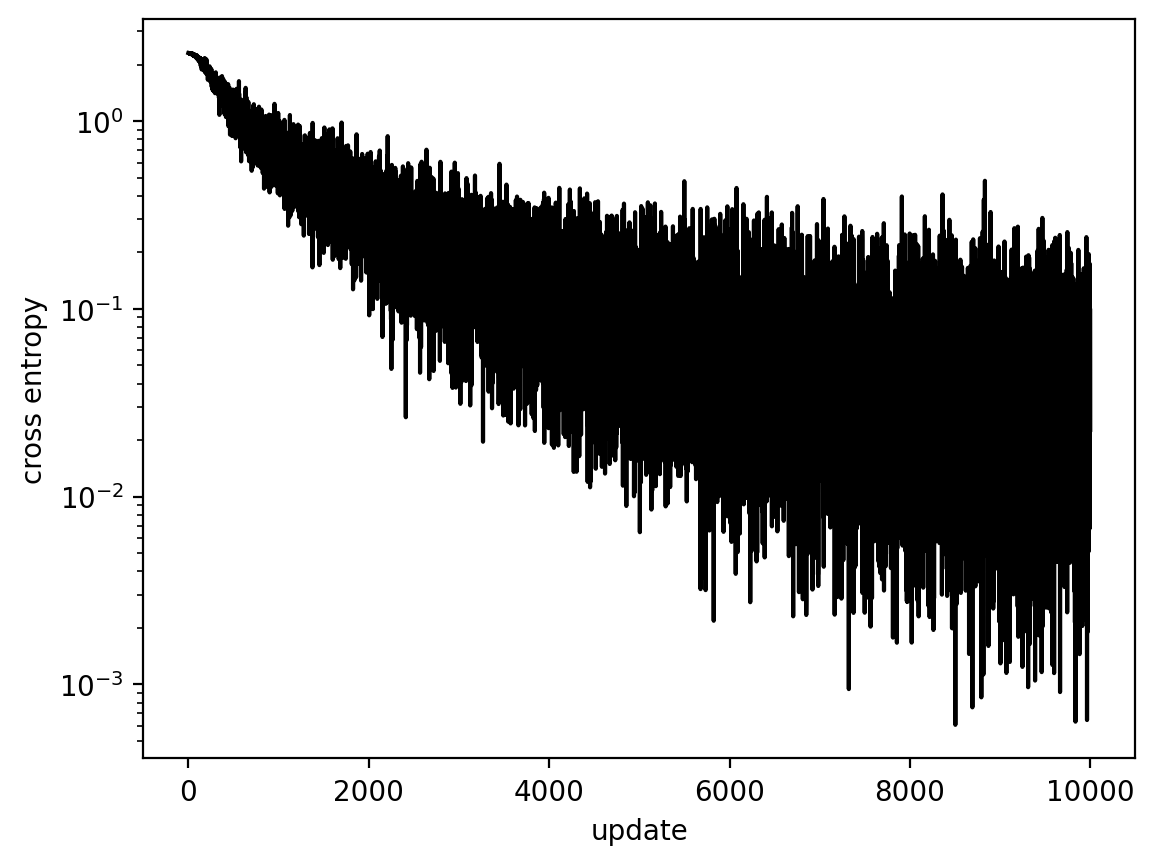

In [8]:
N_features = [7*7, 20]
N_head = 10
N_MLP = 2
N_blocks = 6
length = 4*4
N_classes = 10
N_c_layers = 3
N_c_features = 20
N_updates = 10000
N_batch = 50
learning_rate = 1e-4
key = random.PRNGKey(11)

keys = random.split(key, 3)
model = ViT_classifier(keys[0], N_features, N_head, N_MLP, N_blocks, length, N_classes, N_c_layers, N_c_features)
model_size = sum(tree_map(jnp.size, tree_flatten(model)[0]))
print(f"Model size: {model_size}")

inds = random.choice(keys[1], N_train, (N_updates, N_batch))
optim = optax.lion(learning_rate=learning_rate)
opt_state = optim.init(eqx.filter(model, eqx.is_array))
carry = [features, classes, model, opt_state]
make_step_scan_ = lambda a, b: make_step_scan(a, b, optim)

start = time.time()
carry, history = scan(make_step_scan_, carry, inds)
model = carry[2]
stop = time.time()
print(f"Trainig time: {stop - start}")

plt.yscale("log")
plt.plot(history, color="black")
plt.xlabel("update")
plt.ylabel("cross entropy")

inds = jnp.arange(features.shape[0])
_, hits_and_misses = scan(compute_accuracy, [features, classes, model], inds.reshape(-1, N_batch))
hits_and_misses = hits_and_misses.reshape(-1,)
train_accuracy = jnp.mean(hits_and_misses[:N_train])
test_accuracy = jnp.mean(hits_and_misses[N_train:])

print(f"Train accuracy {train_accuracy}")
print(f"Test accuracy {test_accuracy}")